OpenCV, librería para tratamiento y procesamiento de imagenes

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt

In [2]:
path_img = "/content/drive/MyDrive/dataset_imagenes/train/Contempt/Contempt_0.jpg"

Lectura de una imagen de forma manual

In [3]:
import cv2 as cv
import tkinter as tk
from tkinter import messagebox
from tkinter import filedialog
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Función para capturar imágenes desde la cámara
def capture_image():
    cap = cv.VideoCapture(0)
    if not cap.isOpened():
        messagebox.showerror("Error", "No se puede acceder a la cámara.")
        return

    ret, frame = cap.read()
    if ret:
        cv.imwrite("captured_image.jpg", frame)
        cap.release()
        messagebox.showinfo("Captura", "Imagen capturada y guardada como 'captured_image.jpg'.")
    else:
        messagebox.showerror("Error", "No se pudo capturar la imagen.")
        cap.release()

# Configuración de la ventana principal de Tkinter
root = tk.Tk()
root.title("Captura de Imágenes")
root.geometry("300x200")

# Botón para capturar imágenes
btn_capture = tk.Button(root, text="Capturar Imagen", command=capture_image)
btn_capture.pack(pady=20)

# Función para procesar y entrenar el modelo
def process_and_train():
    path_img = "captured_image.jpg"

    img = cv.imread(path_img, cv.IMREAD_COLOR)

    if img is None:
        messagebox.showerror("Error", "No se pudo cargar la imagen capturada.")
        return

    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.show()

    # El resto del procesamiento y entrenamiento del modelo...
    # Aquí debes incluir el código que ya tienes para procesar el dataset y entrenar el modelo
    path_folder = "/content/drive/MyDrive/dataset_imagenes/train"
    class_emotions = os.listdir(path_folder)
    print(class_emotions)

    # Rutas de cada label y sus imágenes
    path_folder_img = [path_folder + "/" + class_emotions2 for class_emotions2 in class_emotions]

    def read_images(labelstr, pathImg):
        images = []
        labels = []
        for img_name in tqdm(os.listdir(pathImg)):
            img_path = pathImg + "/" + img_name
            img = cv.imread(img_path, cv.IMREAD_COLOR)
            if img is not None:
                images.append(img)
                labels.append(labelstr)
        return images, labels

    l_feel = []
    l_target = []
    for class_emotions2, feeling_path in zip(class_emotions, path_folder_img):
        l_img_feelings, l_target_feelings = read_images(class_emotions2, feeling_path)
        l_feel.extend(l_img_feelings)
        l_target.extend(l_target_feelings)

    def resize_images(img):
        new_width = 200
        new_height = 200
        resized_img = cv.resize(img, (new_width, new_height))
        return resized_img

    l_feel_resized = [resize_images(img) for img in l_feel]
    l_feel_resized = np.array(l_feel_resized)

    # Codificación de etiquetas
    le = LabelEncoder()
    l_target = le.fit_transform(l_target).astype('float32').reshape(-1, 1)

    # Modelo simple sin convolución
    flattened = tf.keras.layers.Flatten(input_shape=[200, 200, 3])
    oculta1 = tf.keras.layers.Dense(units=31, activation='relu')
    oculta2 = tf.keras.layers.Dense(units=31, activation='relu')
    salida = tf.keras.layers.Dense(units=10, activation='linear')
    model = tf.keras.Sequential([flattened, oculta1, oculta2, salida])

    model.compile(optimizer=tf.keras.optimizers.Adam(0.1), loss='mean_squared_error', metrics=['accuracy'])

    hist = model.fit(l_feel_resized, l_target, epochs=100, verbose=True)
    print("Finishing training the model")

    # Modelo convolucional
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=31, activation='relu'),
        tf.keras.layers.Dense(units=31, activation='relu'),
        tf.keras.layers.Dense(units=10, activation='linear')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(0.1), loss='mean_squared_error', metrics=['accuracy'])

    # Verificar clases únicas
    num_classes = len(np.unique(l_target))
    print(f'Número de clases en el dataset: {num_classes}')

    # División del dataset
    train_images, test_images, train_labels, test_labels = train_test_split(l_feel_resized, l_target, test_size=0.2, random_state=42)
    train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.25, random_state=42)

    # Entrenamiento del modelo convolucional
    hist = model.fit(train_images, train_labels, epochs=100, validation_data=(val_images, val_labels), verbose=True)
    print("Finishing training the model")

    # Evaluar el modelo
    loss, accuracy = model.evaluate(test_images, test_labels)
    print(f'Precisión en el conjunto de prueba: {accuracy:.2f}')
    print(f'Pérdida en el conjunto de prueba: {loss:.2f}')

    # Predicciones y matriz de confusión
    y_pred = model.predict(test_images)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_labels.flatten()

    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Matriz de Confusión')
    plt.show()

    emotion_labels = [f'Emoción{i+1}' for i in range(num_classes)]
    report = classification_report(y_true, y_pred_classes, target_names=emotion_labels)
    print(report)

    # Graficar precisión y pérdida
    plt.figure(figsize=(12, 4))

    # Precisión
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['accuracy'], label='Precisión de Entrenamiento')
    plt.plot(hist.history['val_accuracy'], label='Precisión de Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()
    plt.title('Precisión de Entrenamiento y Validación')

    # Pérdida
    plt.subplot(1, 2, 2)
    plt.plot(hist.history['loss'], label='Pérdida de Entrenamiento')
    plt.plot(hist.history['val_loss'], label='Pérdida de Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.title('Pérdida de Entrenamiento y Validación')

    plt.show()

# Botón para procesar y entrenar el modelo
btn_train = tk.Button(root, text="Procesar y Entrenar", command=process_and_train)
btn_train.pack(pady=20)

# Ejecutar la ventana principal de Tkinter
root.mainloop()


ModuleNotFoundError: No module named 'tensorflow.python'

<function matplotlib.pyplot.show(close=None, block=None)>

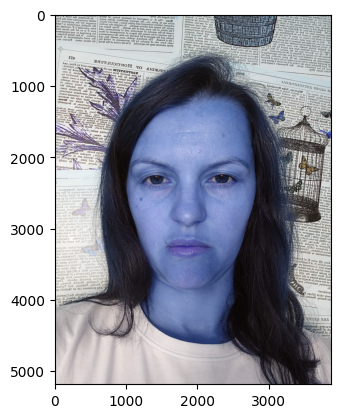

In [ ]:
img = cv.imread(path_img, cv.IMREAD_COLOR)

plt.imshow(img)
plt.show

In [ ]:
#Vectores en cómo está organizada la imagen
print(img)

[[[194 201 194]
  [186 193 186]
  [178 185 178]
  ...
  [159 167 167]
  [175 185 185]
  [185 195 195]]

 [[199 206 199]
  [196 203 196]
  [191 198 191]
  ...
  [168 176 176]
  [178 188 188]
  [183 193 193]]

 [[203 209 204]
  [203 209 204]
  [204 210 205]
  ...
  [180 188 188]
  [181 191 191]
  [180 192 192]]

 ...

 [[224 218 219]
  [224 218 219]
  [224 218 219]
  ...
  [186 180 185]
  [186 178 185]
  [185 177 184]]

 [[223 217 218]
  [224 218 219]
  [224 218 219]
  ...
  [188 182 187]
  [188 180 187]
  [186 178 185]]

 [[223 217 218]
  [223 217 218]
  [224 218 219]
  ...
  [190 184 189]
  [190 182 189]
  [187 179 186]]]


Lectura de varias imágenes

In [ ]:
import os
from tqdm import tqdm #parte grafica
import random #manejar aleatoriedad
import numpy as np
import pandas as pd

In [ ]:
#Dirección de la carpeta en el drive
path_folder = "/content/drive/MyDrive/dataset_imagenes/train"

In [ ]:
#Extracción de los label dentro del dataset
class_emotions= os.listdir(path_folder)
print(class_emotions)

['sad', 'fear', 'Contempt', 'happy', 'disgust', 'angry', 'neutral', 'surprised']


In [ ]:
#Rutas de cada label y sus imagenes
path_folder_img = [path_folder +  "/" + class_emotions2 for class_emotions2 in class_emotions]
path_folder_img

['/content/drive/MyDrive/dataset_imagenes/train/sad',
 '/content/drive/MyDrive/dataset_imagenes/train/fear',
 '/content/drive/MyDrive/dataset_imagenes/train/Contempt',
 '/content/drive/MyDrive/dataset_imagenes/train/happy',
 '/content/drive/MyDrive/dataset_imagenes/train/disgust',
 '/content/drive/MyDrive/dataset_imagenes/train/angry',
 '/content/drive/MyDrive/dataset_imagenes/train/neutral',
 '/content/drive/MyDrive/dataset_imagenes/train/surprised']

Acceso a todas las imagenes del dataset de forma elegante

In [ ]:
def read_images(labelstr, pathImg:list)->list:
  images = []
  labels = []
  for img in tqdm(os.listdir(pathImg)):
    img_path = pathImg + "/" + img
    img = cv.imread(img_path, cv.IMREAD_COLOR)
    images.append(img)
    labels.append(labelstr)
  return images, labels

In [ ]:
l_feel = []
l_target = []
for class_emotions2, feeling_path in zip(class_emotions, path_folder_img):
  l_img_feelings, l_target_feelings = read_images(class_emotions2, feeling_path)
  l_feel.extend(l_img_feelings)
  l_target.extend(l_target_feelings)

100%|██████████| 14/14 [00:25<00:00,  1.82s/it]


Inicio de la confección de la Red Neuronal

Paso 1: Transformar los datos
Aquí se pasan las imágenes a un tamaño fijo, en este caso 200x200x3

In [ ]:
def resize_images(img):
  new_width = 200
  new_height = 200
  resized_img = cv.resize(img, (new_width, new_height))
  return resized_img

In [ ]:
l_feel_resized = [resize_images(img) for img in l_feel]

In [ ]:
l_feel_resized[5].shape

(200, 200, 3)

In [ ]:
l_feel_resized = np.array(l_feel_resized)

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
l_target = encoder.fit_transform(l_target)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
l_target= le.fit_transform(l_target).astype('float32').reshape(-1,1)
l_target

array([[6.],
       [6.],
       [6.],
       [6.],
       [6.],
       [6.],
       [6.],
       [6.],
       [6.],
       [6.],
       [6.],
       [6.],
       [6.],
       [6.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

Paso 2: Armado de la red neuronal

In [ ]:
import tensorflow as tf

In [ ]:
#Primera red neuronal y primer modelo sencilla de Machine Learning, no hay combulusión

flattened = tf.keras.layers.Flatten(input_shape=[200, 200, 3])  #Capa de aplastamiento
oculta1 = tf.keras.layers.Dense(units=31)
oculta2 = tf.keras.layers.Dense(units=31)
salida = tf.keras.layers.Dense(units=10)
model = tf.keras.Sequential([flattened, oculta1, oculta2, salida])

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(0.1),
              loss = 'mean_squared_error', metrics=['accuracy'])


In [ ]:
hist = model.fit(l_feel_resized, l_target, epochs = 100, verbose = True)
print("Finishing training the model")

Epoch 1/100
4/4 [==============================] - 1s 68ms/step - loss: 16614300844032.0000 - accuracy: 0.1250
Epoch 2/100
4/4 [==============================] - 0s 57ms/step - loss: 5388257722368.0000 - accuracy: 0.1250
Epoch 3/100
4/4 [==============================] - 0s 54ms/step - loss: 21700271931392.0000 - accuracy: 0.0893
Epoch 4/100
4/4 [==============================] - 0s 45ms/step - loss: 4630064398336.0000 - accuracy: 0.0804
Epoch 5/100
4/4 [==============================] - 0s 46ms/step - loss: 2168076500992.0000 - accuracy: 0.1071
Epoch 6/100
4/4 [==============================] - 0s 46ms/step - loss: 958984093696.0000 - accuracy: 0.0982
Epoch 7/100
4/4 [==============================] - 0s 59ms/step - loss: 605117546496.0000 - accuracy: 0.0804
Epoch 8/100
4/4 [==============================] - 0s 49ms/step - loss: 663212326912.0000 - accuracy: 0.1071
Epoch 9/100
4/4 [==============================] - 0s 47ms/step - loss: 504352636928.0000 - accuracy: 0.0714
Epoch 10/100

Esta primera prueba tiene muchas perdidas, por ende no es 100% funcional

In [ ]:
import tensorflow as tf

# Definición del modelo convolucional
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=31, activation='relu'),  # Primera capa densa oculta
    tf.keras.layers.Dense(units=31, activation='relu'),  # Segunda capa densa oculta
    tf.keras.layers.Dense(units=10, activation='linear')  # Capa de salida
])

# Compilación del modelo
model.compile(optimizer=tf.keras.optimizers.Adam(0.1), loss='mean_squared_error', metrics=['accuracy'])

# Entrenamiento del modelo
hist = model.fit(l_feel_resized, l_target, epochs=100, verbose=True)

print("Finishing training the model")


Epoch 1/100
4/4 [==============================] - 10s 2s/step - loss: 2766961008181248.0000 - accuracy: 0.0357
Epoch 2/100
4/4 [==============================] - 10s 2s/step - loss: 2539793940480.0000 - accuracy: 0.0804
Epoch 3/100
4/4 [==============================] - 8s 2s/step - loss: 13187026.0000 - accuracy: 0.0804
Epoch 4/100
4/4 [==============================] - 9s 2s/step - loss: 778.9793 - accuracy: 0.1161
Epoch 5/100
4/4 [==============================] - 9s 2s/step - loss: 211.9426 - accuracy: 0.0804
Epoch 6/100
4/4 [==============================] - 8s 2s/step - loss: 55.8086 - accuracy: 0.1250
Epoch 7/100
4/4 [==============================] - 9s 2s/step - loss: 55.1009 - accuracy: 0.0893
Epoch 8/100
4/4 [==============================] - 7s 2s/step - loss: 46.6927 - accuracy: 0.1786
Epoch 9/100
4/4 [==============================] - 9s 2s/step - loss: 22.5208 - accuracy: 0.0536
Epoch 10/100
4/4 [==============================] - 11s 3s/step - loss: 18.6939 - accuracy: 

Inicio

In [ ]:
import tensorflow as tf

# Definición del modelo convolucional
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=31, activation='relu'),  # Primera capa densa oculta
    tf.keras.layers.Dense(units=31, activation='relu'),  # Segunda capa densa oculta
    tf.keras.layers.Dense(units=8, activation='linear')  # Capa de salida
])

# Compilación del modelo
model.compile(optimizer=tf.keras.optimizers.Adam(0.1), loss='mean_squared_error', metrics=['accuracy'])

In [ ]:
# Verificar las clases únicas en el dataset
num_classes = len(np.unique(l_target))
print(f'Número de clases en el dataset: {num_classes}')

Número de clases en el dataset: 8


In [ ]:
from sklearn.model_selection import train_test_split

# Supongamos que tienes tus datos y etiquetas en arrays llamados l_feel_resized y l_target
train_images, test_images, train_labels, test_labels = train_test_split(l_feel_resized, l_target, test_size=0.2, random_state=42)
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2


In [ ]:
# Entrenar el modelo
hist = model.fit(train_images, train_labels, epochs=100, validation_data=(val_images, val_labels), verbose=True)
print("Finishing training the model")


Epoch 1/100
3/3 [==============================] - 8s 2s/step - loss: 3389663083495424.0000 - accuracy: 0.1212 - val_loss: 18917678383104.0000 - val_accuracy: 0.1739
Epoch 2/100
3/3 [==============================] - 5s 1s/step - loss: 9213598236672.0000 - accuracy: 0.1061 - val_loss: 13839.9697 - val_accuracy: 0.0870
Epoch 3/100
3/3 [==============================] - 5s 1s/step - loss: 17348.8438 - accuracy: 0.1061 - val_loss: 12.8395 - val_accuracy: 0.0870
Epoch 4/100
3/3 [==============================] - 7s 2s/step - loss: 16.3281 - accuracy: 0.1061 - val_loss: 58.3589 - val_accuracy: 0.0435
Epoch 5/100
3/3 [==============================] - 5s 1s/step - loss: 38.9949 - accuracy: 0.1364 - val_loss: 12.6658 - val_accuracy: 0.0870
Epoch 6/100
3/3 [==============================] - 6s 2s/step - loss: 16.4016 - accuracy: 0.1515 - val_loss: 10.3066 - val_accuracy: 0.2174
Epoch 7/100
3/3 [==============================] - 6s 1s/step - loss: 12.1499 - accuracy: 0.1061 - val_loss: 5.9440 -

1/1 [==============================] - 1s 1s/step - loss: 4.8760 - accuracy: 0.2174
Precisión en el conjunto de prueba: 0.22
Pérdida en el conjunto de prueba: 4.88
1/1 [==============================] - 2s 2s/step


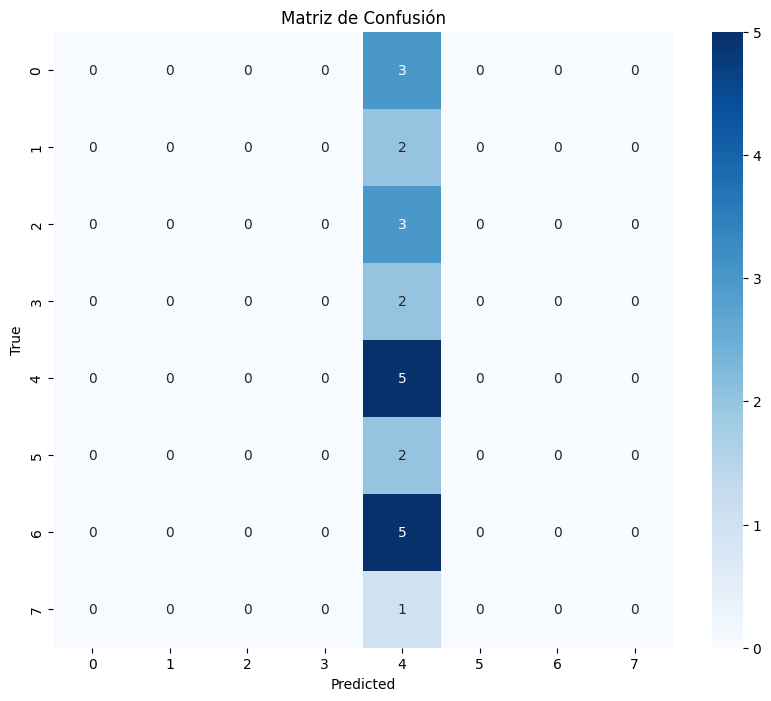

              precision    recall  f1-score   support

    Emoción1       0.00      0.00      0.00         3
    Emoción2       0.00      0.00      0.00         2
    Emoción3       0.00      0.00      0.00         3
    Emoción4       0.00      0.00      0.00         2
    Emoción5       0.22      1.00      0.36         5
    Emoción6       0.00      0.00      0.00         2
    Emoción7       0.00      0.00      0.00         5
    Emoción8       0.00      0.00      0.00         1

    accuracy                           0.22        23
   macro avg       0.03      0.12      0.04        23
weighted avg       0.05      0.22      0.08        23



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(test_images, test_labels)
print(f'Precisión en el conjunto de prueba: {accuracy:.2f}')
print(f'Pérdida en el conjunto de prueba: {loss:.2f}')

# Generar predicciones en el conjunto de prueba
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_labels  # Asegurarse de usar test_labels directamente

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred_classes)

# Graficar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusión')
plt.show()

# Generar el reporte de clasificación
emotion_labels = [f'Emoción{i+1}' for i in range(8)]  # Crear etiquetas dinámicamente
report = classification_report(y_true, y_pred_classes, target_names=emotion_labels)
print(report)


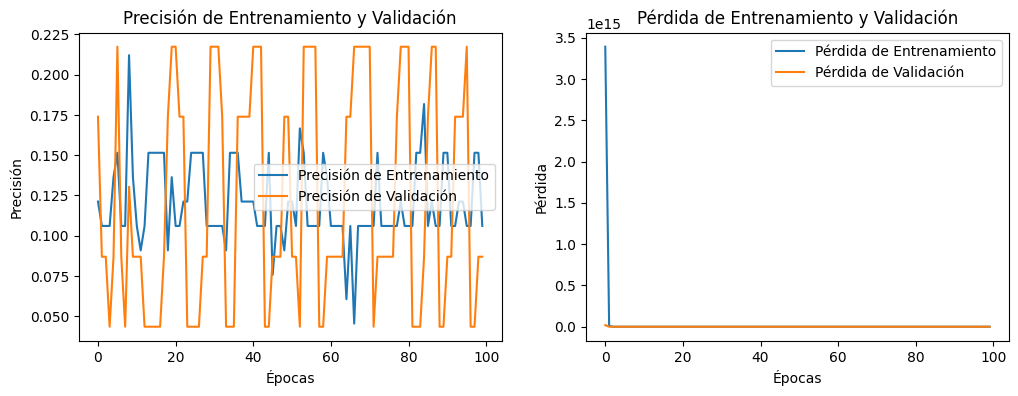

In [ ]:
# Graficar precisión y pérdida
plt.figure(figsize=(12, 4))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'], label='Precisión de Entrenamiento')
plt.plot(hist.history['val_accuracy'], label='Precisión de Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.title('Precisión de Entrenamiento y Validación')

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(hist.history['val_loss'], label='Pérdida de Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Pérdida de Entrenamiento y Validación')

plt.show()
